In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# 0. Ładowanie danych do zadania

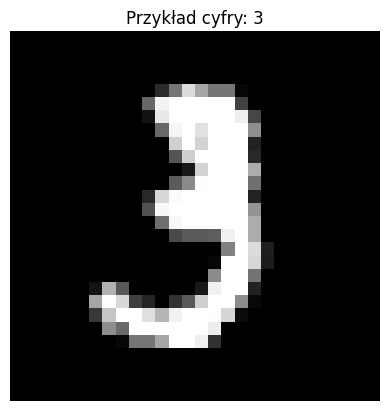

Kształt tensora: (60000, 28, 28)


In [2]:
# ładowanie zbioru danych
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

n = 10

plt.imshow(x_train[n], cmap='gray')
plt.title(f"Przykład cyfry: {y_train[n]}")
plt.axis('off')
plt.show()

print(f"Kształt tensora: {x_train.shape}")

#1. Baseline model

Z tym może być trochę zabawy, użyję modelu drzew decyzyjnych z poprzedniego zadania.

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# przekształcanie danych

batch_size = 2000

x_train_reshaped = x_train.reshape(x_train.shape[0], -1)
x_test_reshaped = x_test.reshape(x_test.shape[0], -1)

model = DecisionTreeClassifier(max_depth=7, random_state=42)
model.fit(x_train_reshaped[:batch_size], y_train[:batch_size]) # uczenie
y_pred = model.predict(x_test_reshaped)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.79      0.81       980
           1       0.91      0.90      0.90      1135
           2       0.59      0.73      0.65      1032
           3       0.59      0.62      0.60      1010
           4       0.63      0.67      0.65       982
           5       0.49      0.63      0.55       892
           6       0.79      0.54      0.64       958
           7       0.78      0.80      0.79      1028
           8       0.74      0.57      0.65       974
           9       0.63      0.59      0.61      1009

    accuracy                           0.69     10000
   macro avg       0.70      0.68      0.69     10000
weighted avg       0.70      0.69      0.69     10000



Accuracy: 0.69
To nie jest skuteczność, której szukamy

Teraz próba z regresją logistyczną

In [4]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(x_train_reshaped[:batch_size], y_train[:batch_size]) # uczenie
y_pred = model.predict(x_test_reshaped)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       980
           1       0.96      0.97      0.96      1135
           2       0.83      0.88      0.85      1032
           3       0.85      0.81      0.83      1010
           4       0.86      0.87      0.86       982
           5       0.75      0.81      0.78       892
           6       0.90      0.88      0.89       958
           7       0.87      0.88      0.87      1028
           8       0.82      0.75      0.78       974
           9       0.83      0.81      0.82      1009

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



Accuracy: 0.86.

Żeby użyć tego modelu musiałem zmniejszyć rozmiar próbki treningowej, bo bez tego napotykaliśmy na błąd zbyt wielu iteracji. Tutaj skuteczność jest większa, ale nieidealna i baaaardzo dużo czekania.

# 2. Model NN

Będziemy używać danych po przekształceniu

In [5]:
# sprawdzamy ilość próbek

x_train.shape

(60000, 28, 28)

In [6]:
x_train_reshaped = x_train.reshape(x_train.shape[0], -1)
x_test_reshaped = x_test.reshape(x_test.shape[0], -1)

# każdy obrazek dwuwymiarowy 28x28 przekształcany jest w wektor jednowymiarowy o długości 784
# (pierwsza zmienna przechowuje ilość próbek)

batch_size = 60000 # ilość próbek

batch_size_train = 48000# ilość próbek

x_train_simple = x_train_reshaped[:batch_size_train]
y_train_simple = y_train[:batch_size_train]

x_val_simple = x_train_reshaped[batch_size_train:batch_size]
y_val_simple = y_train[batch_size_train:batch_size]

print(f"Kształt tensora 1: {x_train_simple.shape}")
print(f"Kształt tensora 2: {x_val_simple.shape}")

Kształt tensora 1: (48000, 784)
Kształt tensora 2: (12000, 784)


In [7]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

input_dim = 28 * 28 # rozmiar obrazka
hidden_dim = 128 # wybrana ilość neuronów
output_dim = 10 # ilość możliwości outputu

model = Model(input_dim, hidden_dim, output_dim)

# przepuszczamy przykładowy tensor i wypisujemy kształt inputu i outputu

sample_input = x_train_simple[0:10]

output_tensor = model(torch.tensor(sample_input, dtype=torch.float32))

print(f"Kształt wejściowego tensora: {sample_input.shape}")
print(f"Kształt wyjściowego tensora z sieci: {output_tensor.shape}")

Kształt wejściowego tensora: (10, 784)
Kształt wyjściowego tensora z sieci: torch.Size([10, 10])


In [8]:
class SimpleDataset(Dataset):
    def __init__(self, data, labels):
        if len(data) != len(labels):
            raise ValueError("Data and labels must have the same length")
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

train_dataset = SimpleDataset(x_train_simple, y_train_simple)
val_dataset = SimpleDataset(x_val_simple, y_val_simple)

print(f"Rozmiar zbioru danych: {len(train_dataset)}")
print(f"Rozmiar zbioru danych do walidacji: {len(val_dataset)}")

Rozmiar zbioru danych: 48000
Rozmiar zbioru danych do walidacji: 12000


Prosty trening modelu

In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

test_dataset = SimpleDataset(x_test_reshaped, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

lr = 1e-3
EPOCHS = 7

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
import time

def run_epoch(loader, model, train: bool): # funkcja przejścia przez jedną epokę
    epoch_loss, correct, total = 0.0, 0, 0
    if train:
        model.train()
    else:
        model.eval()
    for xb, yb in loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        if train:
            optimizer.zero_grad()
        with torch.set_grad_enabled(train):
            logits = model(xb)
            loss = criterion(logits, yb)
            if train:
                loss.backward()
                optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
        preds = logits.argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
    return epoch_loss / total, correct / total

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
start = time.time()
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(train_dataloader, model, train=True)
    va_loss, va_acc = run_epoch(val_dataloader, model, train=False)
    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)
    print(f"Ep {epoch:02d}/{EPOCHS} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")
print(f"Czas treningu: {time.time()-start:.1f}s")

Ep 01/7 | train loss 31.8695 acc 0.0642 | val loss 21.5282 acc 0.1492
Ep 02/7 | train loss 21.8491 acc 0.1485 | val loss 15.9973 acc 0.2794
Ep 03/7 | train loss 16.3087 acc 0.2807 | val loss 11.9769 acc 0.4442
Ep 04/7 | train loss 12.1154 acc 0.4358 | val loss 9.4443 acc 0.5385
Ep 05/7 | train loss 9.5768 acc 0.5358 | val loss 7.5495 acc 0.5872
Ep 06/7 | train loss 7.7720 acc 0.5783 | val loss 6.2549 acc 0.6210
Ep 07/7 | train loss 6.5244 acc 0.6119 | val loss 5.1038 acc 0.6468
Czas treningu: 12.2s


# Sprawdzenie skuteczności modelu

Output po pierwszym trenowaniu przy 7 epokach wyglądał następująco:

Ep 01/7 | train loss 32.1381 acc 0.0846 | val loss 20.5923 acc 0.1808

Ep 02/7 | train loss 20.7588 acc 0.1765 | val loss 16.2530 acc 0.3494

Ep 03/7 | train loss 16.4458 acc 0.3394 | val loss 13.1035 acc 0.4984

Ep 04/7 | train loss 13.3191 acc 0.4884 | val loss 10.7444 acc 0.5850

Ep 05/7 | train loss 10.9520 acc 0.5736 | val loss 8.4325 acc 0.6440

Ep 06/7 | train loss 8.6417 acc 0.6307 | val loss 6.1404 acc 0.6857

Ep 07/7 | train loss 6.3929 acc 0.6726 | val loss 4.1212 acc 0.7148

Czas treningu: 13.7s

Możemy więc wywnioskować, że na początku z każdą epoką zmiany są ogromne, później bardzo maleją, ale progres idzie w górę. Na pewno też kosztuje nas to dużo czasu, to jest mały database więc nie widać tego aż tak dobrze.

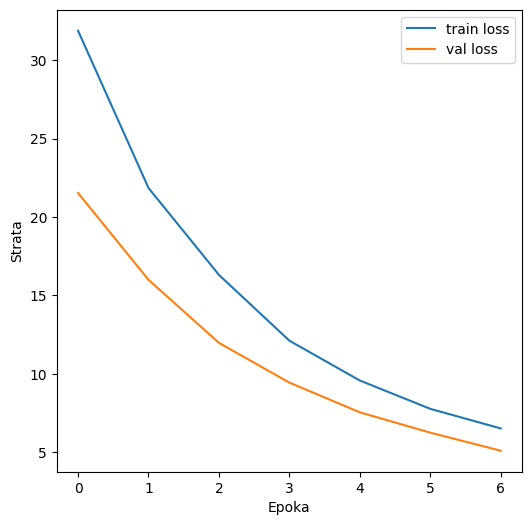

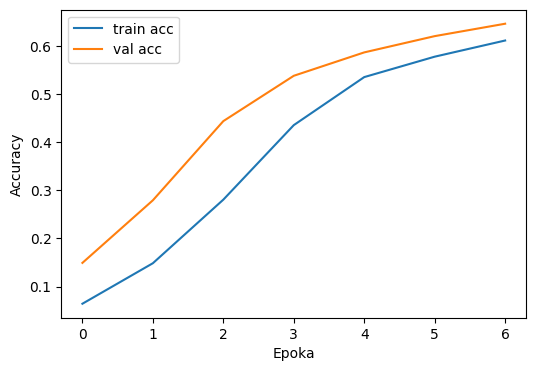

In [11]:
def plot_history(history):
    plt.figure(figsize=(6,6))
    plt.plot(history["train_loss"], label="train loss")
    plt.plot(history["val_loss"], label="val loss")
    plt.xlabel("Epoka")
    plt.ylabel("Strata")
    plt.legend()
    plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(history["train_acc"], label="train acc")
    plt.plot(history["val_acc"], label="val acc")
    plt.xlabel("Epoka")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

plot_history(history)

Dokładność nie jest zadowalająca, tyle epok nie wystarczy, kontynuuję więc uczenie

In [12]:
EPOCHS = 30 # duża liczba epok

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
start = time.time()
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(train_dataloader, model, train=True)
    va_loss, va_acc = run_epoch(val_dataloader, model, train=False)
    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)
    print(f"Ep {epoch:02d}/{EPOCHS} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")
print(f"Czas treningu: {time.time()-start:.1f}s")

Ep 01/30 | train loss 5.3818 acc 0.6377 | val loss 3.7792 acc 0.6873
Ep 02/30 | train loss 4.0677 acc 0.6755 | val loss 2.6155 acc 0.7502
Ep 03/30 | train loss 2.8908 acc 0.7322 | val loss 2.2911 acc 0.7730
Ep 04/30 | train loss 2.5339 acc 0.7528 | val loss 2.5462 acc 0.7587
Ep 05/30 | train loss 2.8101 acc 0.7362 | val loss 2.7379 acc 0.7443
Ep 06/30 | train loss 3.0335 acc 0.7241 | val loss 2.5302 acc 0.7566
Ep 07/30 | train loss 2.8193 acc 0.7359 | val loss 2.1417 acc 0.7827
Ep 08/30 | train loss 2.3971 acc 0.7632 | val loss 1.8850 acc 0.8043
Ep 09/30 | train loss 2.0975 acc 0.7844 | val loss 1.7947 acc 0.8111
Ep 10/30 | train loss 1.9857 acc 0.7938 | val loss 1.7593 acc 0.8174
Ep 11/30 | train loss 1.9299 acc 0.8001 | val loss 1.6711 acc 0.8263
Ep 12/30 | train loss 1.8136 acc 0.8096 | val loss 1.5276 acc 0.8416
Ep 13/30 | train loss 1.6367 acc 0.8232 | val loss 1.3913 acc 0.8519
Ep 14/30 | train loss 1.4721 acc 0.8344 | val loss 1.3075 acc 0.8572
Ep 15/30 | train loss 1.3721 acc 0

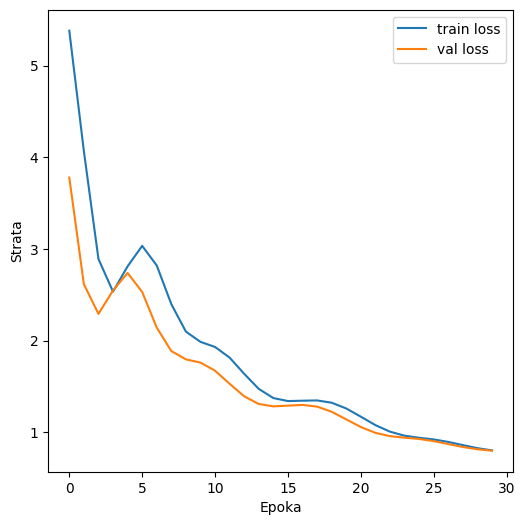

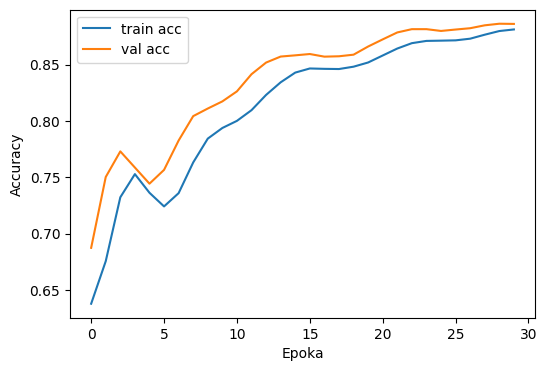

In [13]:
plot_history(history)

Dokładność sięga już 90%.

To może być dobry moment na macierz pomyłek i dalsze ulepszenia sieci.

Test accuracy: 0.8857


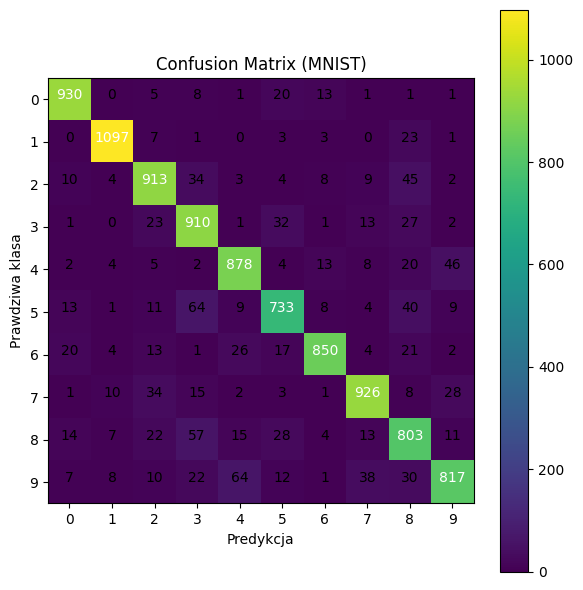

              precision    recall  f1-score   support

           0     0.9319    0.9490    0.9403       980
           1     0.9665    0.9665    0.9665      1135
           2     0.8754    0.8847    0.8800      1032
           3     0.8169    0.9010    0.8569      1010
           4     0.8789    0.8941    0.8864       982
           5     0.8563    0.8217    0.8387       892
           6     0.9424    0.8873    0.9140       958
           7     0.9114    0.9008    0.9061      1028
           8     0.7888    0.8244    0.8062       974
           9     0.8890    0.8097    0.8475      1009

    accuracy                         0.8857     10000
   macro avg     0.8857    0.8839    0.8843     10000
weighted avg     0.8871    0.8857    0.8858     10000



In [14]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(model):
  model.eval()
  all_preds, all_targets = [], []
  with torch.no_grad():
      for xb, yb in test_dataloader:
          xb = xb.to(device, non_blocking=True)
          logits = model(xb)
          preds = logits.argmax(1).cpu().numpy()
          all_preds.append(preds)
          all_targets.append(yb.numpy())

  y_pred = np.concatenate(all_preds)
  y_true = np.concatenate(all_targets)

  test_acc = (y_pred == y_true).mean()
  print(f"Test accuracy: {test_acc:.4f}")


  cm = confusion_matrix(y_true, y_pred)
  plt.figure(figsize=(6,6))
  plt.imshow(cm, interpolation='nearest')
  plt.title("Confusion Matrix (MNIST)")
  plt.colorbar()
  tick_marks = np.arange(10)
  plt.xticks(tick_marks, tick_marks)
  plt.yticks(tick_marks, tick_marks)

  thresh = cm.max() / 2.0
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], 'd'),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('Prawdziwa klasa')
  plt.xlabel('Predykcja')
  plt.tight_layout()
  plt.show()

  print(classification_report(y_true, y_pred, digits=4))

plot_confusion_matrix(model)

Najwięcej pomyłek występuje na linii 9-4 i 9-7, w tym duża większość z nich dotyczy nieprawidłowego wzięcia cyfry za 9.

Powodem jest najprawdopodobniej podobieństwo w kształtach tych cyfr.

In [21]:
class ChangedModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_p):
        super(ChangedModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.dropout1 = nn.Dropout(p=dropout_p)


        self.fc2 = nn.Linear(hidden_size, hidden_size//2)
        self.bn2 = nn.BatchNorm1d(hidden_size//2)
        self.dropout2 = nn.Dropout(p=dropout_p)

        self.fc3 = nn.Linear(hidden_size//2, hidden_size//4)
        self.bn3 = nn.BatchNorm1d(hidden_size//4)
        self.dropout3 = nn.Dropout(p=dropout_p)

        self.fc4 = nn.Linear(hidden_size//4, output_size)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        return x

input_dim = 28 * 28 # rozmiar obrazka
hidden_dim = 256 # zwiększam ilość warstw ukrytych, może to poprawi dokładność
output_dim = 10 # ilość możliwości outputu
dropout_p = 0.2 # zmieniony dropout

model2 = ChangedModel(input_dim, hidden_dim, output_dim, dropout_p)

# przepuszczamy przykładowy tensor i wypisujemy kształt inputu i outputu

sample_input = x_train_simple[0:10]

output_tensor = model(torch.tensor(sample_input, dtype=torch.float32))

print(f"Kształt wejściowego tensora: {sample_input.shape}")
print(f"Kształt wyjściowego tensora z sieci: {output_tensor.shape}")

Kształt wejściowego tensora: (10, 784)
Kształt wyjściowego tensora z sieci: torch.Size([10, 10])


Tak zmieniony model próbuję ponownie przetrenować

In [22]:
EPOCHS = 30

optimizer = optim.Adam(model2.parameters(), lr=lr) # zapomniałem wstępnie o tej linijce i dalej optimizer dotyczył pierwszego modelu
# przez co dokładność nie przekroczyła 20% i zaczęła spadać XD

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
start = time.time()
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(train_dataloader, model2, train=True)
    va_loss, va_acc = run_epoch(val_dataloader, model2, train=False)
    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)
    print(f"Ep {epoch:02d}/{EPOCHS} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")
print(f"Czas treningu: {time.time()-start:.1f}s")

Ep 01/30 | train loss 2.3811 acc 0.0938 | val loss 2.1234 acc 0.2760
Ep 02/30 | train loss 1.8706 acc 0.5108 | val loss 2.0162 acc 0.4403
Ep 03/30 | train loss 1.6080 acc 0.6747 | val loss 1.9305 acc 0.5696
Ep 04/30 | train loss 1.4408 acc 0.7414 | val loss 1.8497 acc 0.6549
Ep 05/30 | train loss 1.3180 acc 0.7798 | val loss 1.7687 acc 0.7358
Ep 06/30 | train loss 1.2208 acc 0.8082 | val loss 1.6858 acc 0.7889
Ep 07/30 | train loss 1.1406 acc 0.8292 | val loss 1.6022 acc 0.8247
Ep 08/30 | train loss 1.0730 acc 0.8457 | val loss 1.5196 acc 0.8503
Ep 09/30 | train loss 1.0153 acc 0.8586 | val loss 1.4393 acc 0.8692
Ep 10/30 | train loss 0.9653 acc 0.8689 | val loss 1.3621 acc 0.8804
Ep 11/30 | train loss 0.9209 acc 0.8784 | val loss 1.2883 acc 0.8883
Ep 12/30 | train loss 0.8806 acc 0.8853 | val loss 1.2183 acc 0.8957
Ep 13/30 | train loss 0.8436 acc 0.8919 | val loss 1.1524 acc 0.9014
Ep 14/30 | train loss 0.8095 acc 0.8969 | val loss 1.0907 acc 0.9046
Ep 15/30 | train loss 0.7778 acc 0

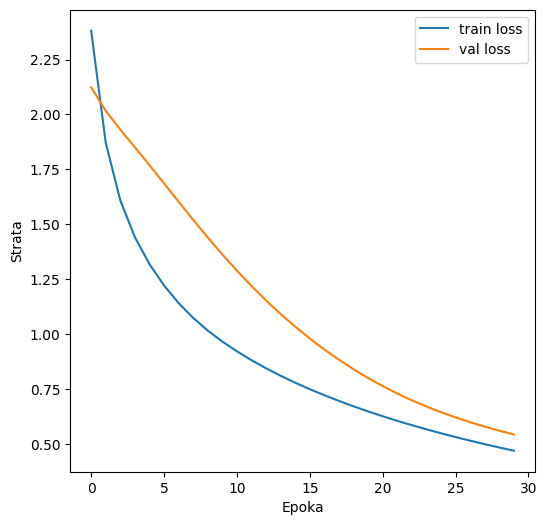

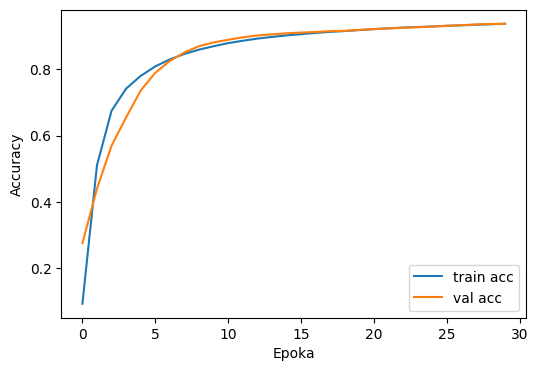

In [23]:
plot_history(history)

Dokładność sięga już 94%, widać poprawę, jednak czas uczenia zwiększył się do ponad 80 sekund.

Test accuracy: 0.9370


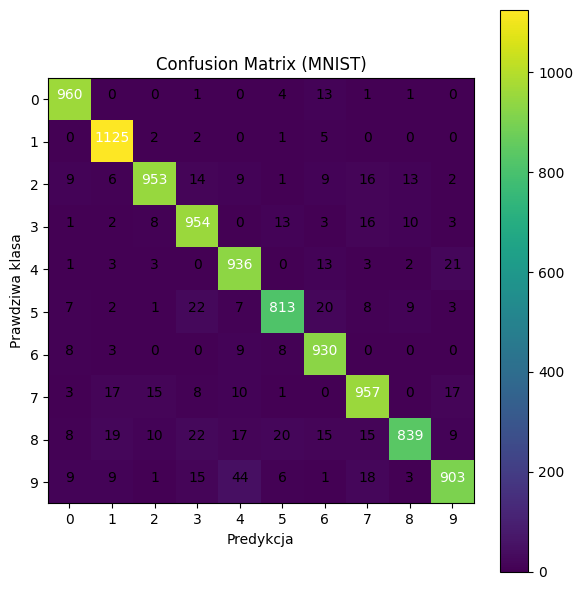

              precision    recall  f1-score   support

           0     0.9543    0.9796    0.9668       980
           1     0.9486    0.9912    0.9694      1135
           2     0.9597    0.9234    0.9412      1032
           3     0.9191    0.9446    0.9316      1010
           4     0.9070    0.9532    0.9295       982
           5     0.9377    0.9114    0.9244       892
           6     0.9217    0.9708    0.9456       958
           7     0.9255    0.9309    0.9282      1028
           8     0.9567    0.8614    0.9065       974
           9     0.9426    0.8949    0.9181      1009

    accuracy                         0.9370     10000
   macro avg     0.9373    0.9361    0.9361     10000
weighted avg     0.9375    0.9370    0.9367     10000



In [24]:
plot_confusion_matrix(model2)

Pomyłek jest znacznie mniej, występują głównie na linii 9-4, tak jak poprzednio, teraz jednak 9 są błędnie brane za 4.

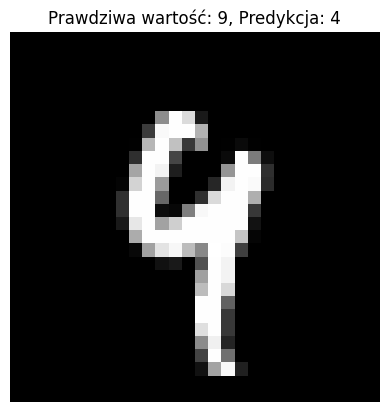

In [35]:
model2.eval()
images, labels = next(iter(test_dataloader))

a = 9 # prawdziwa wartość
b = 4 # predykcja

with torch.no_grad():
  logits = model2(images)
preds = logits.argmax(1)

# szukanie błędnej predykcji w batchu
error_idx = None
for i in range(len(images)):
  if labels[i] == a and preds[i] == b:
      error_idx = i
      break

if error_idx is not None:
  plt.imshow(images[error_idx].cpu().view(28,28), cmap='gray')
  plt.title(f"Prawdziwa wartość: {a}, Predykcja: {b}")
  plt.axis('off')
  plt.show()

Dzięki wizualizacji pomyłki możemy zauważyć faktyczne podobieństwo między tymi dwoma cyframi.

(Ale można trafić też na takie łatwo rozróżnialne)

In [20]:
import os

#zapis modelu
save_path = "mnist_cnn.pt"
torch.save(model.state_dict(), save_path)
print(f"Model zapisany do: {os.path.abspath(save_path)}")

Model zapisany do: /content/mnist_cnn.pt


Wnioski:

* Sieć neuronowa to rozwiązanie dużo skuteczniejsze od baselinowych modeli
* Zmiany dokonane między modelami 1 i 2 zwiększyły accuracy, jednak jest jeszcze daleko do 100%
* Zadowalający wynik klasyfikacji sięgałby powyżej 97% accuracy
* Dalsze uczenie tego modelu nie przyniosłoby skutków, co widać na wykresie epoch/accuracy - ma kształt funkcji logarytmicznej i zaszedł już dość daleko
